In [40]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [21]:
iris = pd.read_csv('iris.data', header=None)
iris.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
iris

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [22]:
def first_population(number_of_genotypes):
    genotypes = np.array([[random.randint(0, 2) for _ in range(150)] for _ in range(number_of_genotypes)])
    genotypes = np.array([np.append(genotypes[i], 0.0) for i in range(number_of_genotypes)])
    return genotypes

In [23]:
def distance(genotype):
    cluster0_indices, cluster1_indices, cluster2_indices = np.array([]), np.array([]), np.array([])

    for i in range(0, 150):
        if genotype[i] == 0:
            cluster0_indices = np.append(cluster0_indices, i)
        if genotype[i] == 1:
            cluster1_indices = np.append(cluster1_indices, i)
        if genotype[i] == 2:
            cluster2_indices = np.append(cluster2_indices, i)

    cluster0 = iris.iloc[cluster0_indices]
    cluster1 = iris.iloc[cluster1_indices]
    cluster2 = iris.iloc[cluster2_indices]

    difference0 = np.mean([np.linalg.norm(cluster0['sepal_length'] - cluster0['sepal_length'].mean()), np.linalg.norm(cluster0['sepal_width'] - cluster0['sepal_width'].mean()), np.linalg.norm(cluster0['petal_length'] - cluster0['petal_length'].mean()), np.linalg.norm(cluster0['petal_width'] - cluster0['petal_width'].mean())])
    difference1 = np.mean([np.linalg.norm(cluster1['sepal_length'] - cluster1['sepal_length'].mean()), np.linalg.norm(cluster1['sepal_width'] - cluster1['sepal_width'].mean()), np.linalg.norm(cluster1['petal_length'] - cluster1['petal_length'].mean()), np.linalg.norm(cluster1['petal_width'] - cluster1['petal_width'].mean())])
    difference2 = np.mean([np.linalg.norm(cluster2['sepal_length'] - cluster2['sepal_length'].mean()), np.linalg.norm(cluster2['sepal_width'] - cluster2['sepal_width'].mean()), np.linalg.norm(cluster2['petal_length'] - cluster2['petal_length'].mean()), np.linalg.norm(cluster2['petal_width'] - cluster2['petal_width'].mean())])

    size_of_cluster0, size_of_cluster1, size_of_cluster2 = len(cluster0) / 150, len(cluster1) / 150, len(cluster2) / 150

    difference = np.sum([difference0 * size_of_cluster0, difference1 * size_of_cluster1, difference2 * size_of_cluster2])

    return difference

In [24]:
def distances(genotypes):
    for genotype in genotypes:
        genotype[-1] = distance(genotype[:-1])
    return genotypes

In [25]:
def selection(genotypes, number_of_remaining_genotypes):
    gens = np.array(sorted(genotypes, key=lambda x: x[-1]))
    return gens[:number_of_remaining_genotypes]

In [26]:
def mutation(child):
    i = random.randint(0, 149)
    child[i] = random.randint(0, 2)
    return child

In [27]:
def crossover(genotypes, number_of_children_per_couple, rate_of_mutations):
    gens = genotypes.copy()
    for parent1 in genotypes:
        for parent2 in genotypes:
            for i in range(number_of_children_per_couple):
                child = np.array([random.randint(0, 1) for _ in range(150)])
                child = np.append(child, 0.0)
                for j in range(150):
                    if random.random() < 0.5:
                        child[j] = parent1[j]
                    else:
                        child[j] = parent2[j]

                if random.random() < rate_of_mutations:
                    child = mutation(child)

                gens = np.append(gens, [child], axis=0)
    return gens

In [28]:
def cluster_accuracy(predicted_labels):
    actual_labels = iris['class']

    actual_labels1 = actual_labels.replace('Iris-setosa', 0.0)
    actual_labels1 = actual_labels1.replace('Iris-versicolor', 1.0)
    actual_labels1 = actual_labels1.replace('Iris-virginica', 2.0)
    perm1 = np.mean(actual_labels1 == predicted_labels)

    max_perm = perm1
    best_labels = actual_labels1

    actual_labels2 = actual_labels.replace('Iris-setosa', 0.0)
    actual_labels2 = actual_labels2.replace('Iris-versicolor', 2.0)
    actual_labels2 = actual_labels2.replace('Iris-virginica', 1.0)
    perm2 = np.mean(actual_labels2 == predicted_labels)

    if perm2 > max_perm:
        max_perm = perm2
        best_labels = actual_labels2

    actual_labels3 = actual_labels.replace('Iris-setosa', 1.0)
    actual_labels3 = actual_labels3.replace('Iris-versicolor', 0.0)
    actual_labels3 = actual_labels3.replace('Iris-virginica', 2.0)
    perm3 = np.mean(actual_labels3 == predicted_labels)

    if perm3 > max_perm:
        max_perm = perm3
        best_labels = actual_labels3

    actual_labels4 = actual_labels.replace('Iris-setosa', 1.0)
    actual_labels4 = actual_labels4.replace('Iris-versicolor', 2.0)
    actual_labels4 = actual_labels4.replace('Iris-virginica', 0.0)
    perm4 = np.mean(actual_labels4 == predicted_labels)

    if perm4 > max_perm:
        max_perm = perm4
        best_labels = actual_labels4

    actual_labels5 = actual_labels.replace('Iris-setosa', 2.0)
    actual_labels5 = actual_labels5.replace('Iris-versicolor', 1.0)
    actual_labels5 = actual_labels5.replace('Iris-virginica', 0.0)
    perm5 = np.mean(actual_labels5 == predicted_labels)

    if perm5 > max_perm:
        max_perm = perm5
        best_labels = actual_labels5

    actual_labels6 = actual_labels.replace('Iris-setosa', 2.0)
    actual_labels6 = actual_labels6.replace('Iris-versicolor', 0.0)
    actual_labels6 = actual_labels6.replace('Iris-virginica', 1.0)
    perm6 = np.mean(actual_labels6 == predicted_labels)

    if perm6 > max_perm:
        best_labels = actual_labels6

    return best_labels, metrics.accuracy_score(best_labels, predicted_labels)

In [29]:
#first population
first_population = first_population(number_of_genotypes=1000)
first_population = distances(first_population)
first_population = selection(first_population, number_of_remaining_genotypes=10)

new_genotypes = first_population.copy()
best_distances = []

print('first population is created')

# over generations
for i in range(150):
    new_genotypes = crossover(new_genotypes, number_of_children_per_couple = 2, rate_of_mutations = 0.1)
    new_genotypes = distances(new_genotypes)
    new_genotypes = selection(new_genotypes, number_of_remaining_genotypes=10)
    print(str(i) + ': ' + str(new_genotypes[0][-1]))
    best_distances.append(new_genotypes[0][-1])

first population is created
0: 6.1332732043813305
1: 6.113404957972232
2: 5.890898350281294
3: 5.531615731245617
4: 5.285622895179847
5: 5.022554312589123
6: 4.646977871942993
7: 4.568383574521626
8: 4.421288459233139
9: 4.347908664248454
10: 4.320442817853111
11: 4.285935935372425
12: 4.261748739891771
13: 4.209776948150011
14: 4.197304389422364
15: 4.1552016219409165
16: 4.1246997756421155
17: 4.0908055174913835
18: 4.0908055174913835
19: 4.02520958127779
20: 3.9701451200199607
21: 3.9543625372414004
22: 3.897334490164763
23: 3.897334490164763
24: 3.8335727486195736
25: 3.769724927410757
26: 3.741534154744847
27: 3.6730443406778415
28: 3.6193223799679792
29: 3.5787392983058686
30: 3.5452125492979265
31: 3.5452125492979265
32: 3.5190622787279375
33: 3.5190622787279375
34: 3.5190622787279375
35: 3.5164869572375097
36: 3.5153744242336074
37: 3.4452684572249046
38: 3.442882617283445
39: 3.4426994070600316
40: 3.4277759936991163
41: 3.3625820732795275
42: 3.3470719493575425
43: 3.34707194

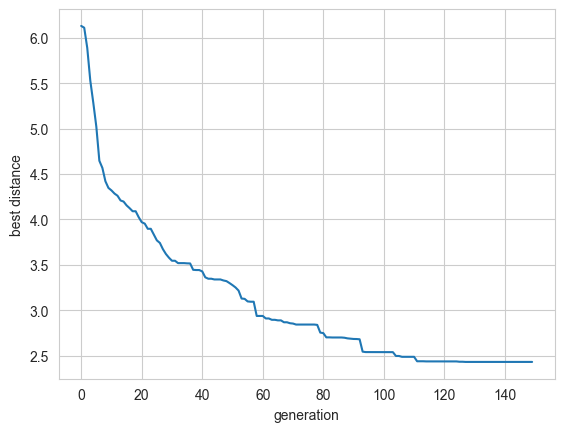

In [30]:
plt.plot(best_distances)
plt.ylabel('best distance')
plt.xlabel('generation')
plt.show()

In [31]:
best_genotype = new_genotypes[0]

In [32]:
predicted_labels = best_genotype[:-1]
best_labels, accuracy = cluster_accuracy(predicted_labels)

print('Accuracy: ' + str(accuracy))

Accuracy: 0.9


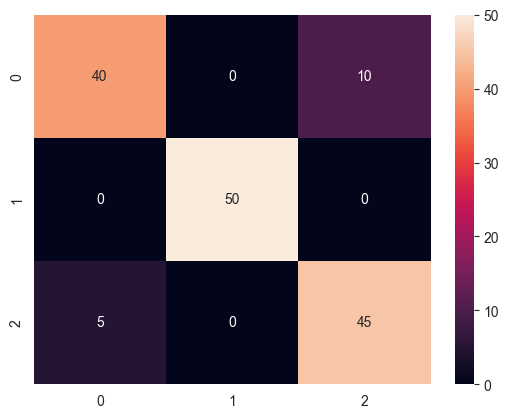

In [33]:
cm = confusion_matrix(best_labels, predicted_labels)
sns.heatmap(cm, annot=True)
plt.show()

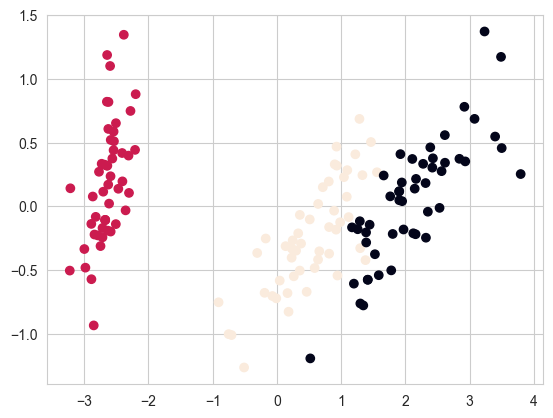

In [37]:
pca = PCA(n_components=2)
pca.fit(iris.iloc[:, :-1])
iris_pca = pca.transform(iris.iloc[:, :-1])
plt.scatter(iris_pca[:, 0], iris_pca[:, 1], c=best_labels)
plt.show()

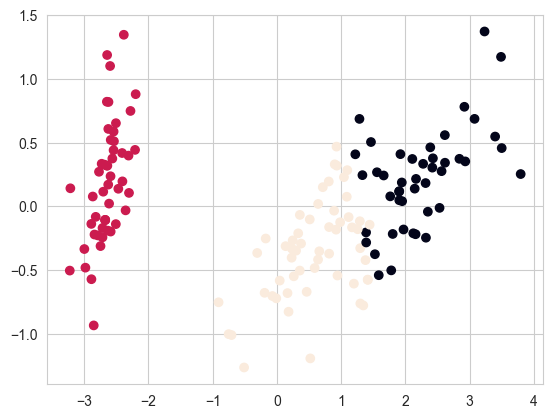

In [38]:
plt.scatter(iris_pca[:, 0], iris_pca[:, 1], c=predicted_labels)
plt.show()

Accuracy: 0.8866666666666667


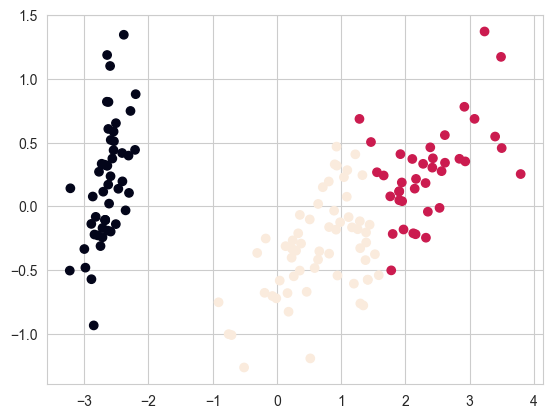

In [41]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(iris_pca)
kmeans_labels = kmeans.labels_

_, kmeans_accuracy = cluster_accuracy(kmeans_labels)
print('Accuracy: ' + str(kmeans_accuracy))

plt.scatter(iris_pca[:, 0], iris_pca[:, 1], c=kmeans_labels)
plt.show()